# Neural Machine Translation
#### Applied Text Mining - Utrecht Summer School

Welcome to the seventh practical of the course “Applied Text Mining”. 

In this practical, we will create models for neural machine translation. Today we are curious to see how a simple deep learning based model translates a sentence into its counterpart. See these examples:

<img src="translation_example.png">

<img src="translation_example2.png">

The objective from this practical is to convert a Dutch sentence to its English counterpart using a Neural Machine Translation (NMT) system. We will implement this task by building a simple Sequence-to-Sequence model with the help of Keras library.

Today we will use the following libraries. Take care to have them installed!

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
# matplotlib inline
pd.set_option('display.max_colwidth', 200)

### Let's get started!

1\. **In this practical we will use a dataset of tab-delimited Bilingual Sentence Pairs from http://www.manythings.org/anki/. Use the following two functions (read_text and to_lines) and read the nld.txt dataset (provided in the data folder). This dataset contains phrases in Dutch with their translation in English. Convert the text sequences to an array and check the first items in your array.**

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [4]:
data = read_text("nld-eng/nld.txt")
nld_eng = to_lines(data)
nld_eng = array(nld_eng)

In [5]:
nld_eng.shape

(54972, 3)

In [6]:
nld_eng

array([['Go.', 'Lopen!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7764436 (LinguisticFusion)'],
       ['Go.', 'Vooruit.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7915821 (Elsofie)'],
       ['Hi.', 'Hoi.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #537889 (Dorenda)'],
       ...,
       ['Always use distilled water in steam irons because using ordinary water will cause a mineral build-up over time that will clog the steam holes.',
        'Gebruik altijd gedistilleerd water in stoomstrijkijzers, want gewoon water zorgt voor mineraalophoping dat de stoomgaatjes na verloop van tijd verstopt.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3020388 (Delian) & #3037091 (Citrine)'],
       ["If you translate from your second language into your own native language, rather than the other way around, you're less likely to make mistakes.",
        'Als je vanuit je tweede taal naar je eigen moedertaal v

Using a code like nld_eng = nld_eng[:1000,:], you can use a subset of data, for example the first 1000 sentence pairs, to reduce the training time of the model. Be aware that you will lose the performance.

# Pre-processing

2\. **The maketrans() function is a function from the library str that is used to construct a transition table i.e specify a list of characters that need to be replaced in a string or the characters that need to be deleted from the string. To use this transition table, you can use the translate() function and apply that on a string. It is also possible to use these functions to remove the punctuations. Similar to the example below, apply the maketrans() function to remove punctuations from the nld_eng array.**

In [39]:
# specify the list of characters that need to be replaced
str1 = "mtex"

# specify the list of characters with which the characters need to be replaced
str2 = "dwoo"

# specify the list of characters that needs to be deleted
str3 = "u"

# target string 
temp_str = "text mining"

# using maketrans() to construct a translate table
table = temp_str.maketrans(str1, str2, str3)
  
# Printing original string 
print ("The string before translating is : ", end ="")
print (temp_str)
  
# using translate() to make translations.
print ("The string after translating is : ", end ="")
print (temp_str.translate(table))

The string before translating is : text mining
The string after translating is : woow dining


Note that it is possible to replace one character with two or more. You need to supply a dict as argument to maketrans().

In [7]:
nld_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in nld_eng[:,0]]
nld_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in nld_eng[:,1]]

In [8]:
nld_eng

array([['Go', 'Lopen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7764436 (LinguisticFusion)'],
       ['Go', 'Vooruit',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7915821 (Elsofie)'],
       ['Hi', 'Hoi',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #537889 (Dorenda)'],
       ...,
       ['Always use distilled water in steam irons because using ordinary water will cause a mineral buildup over time that will clog the steam holes',
        'Gebruik altijd gedistilleerd water in stoomstrijkijzers want gewoon water zorgt voor mineraalophoping dat de stoomgaatjes na verloop van tijd verstopt',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3020388 (Delian) & #3037091 (Citrine)'],
       ['If you translate from your second language into your own native language rather than the other way around youre less likely to make mistakes',
        'Als je vanuit je tweede taal naar je eigen moedertaal vertaalt in pla

3\. **Convert all words to their lowercase.**

In [9]:
# convert to lowercase
for i in range(len(nld_eng)):
    nld_eng[i,0] = nld_eng[i,0].lower()    
    nld_eng[i,1] = nld_eng[i,1].lower()

In [10]:
nld_eng

array([['go', 'lopen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7764436 (LinguisticFusion)'],
       ['go', 'vooruit',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7915821 (Elsofie)'],
       ['hi', 'hoi',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #537889 (Dorenda)'],
       ...,
       ['always use distilled water in steam irons because using ordinary water will cause a mineral buildup over time that will clog the steam holes',
        'gebruik altijd gedistilleerd water in stoomstrijkijzers want gewoon water zorgt voor mineraalophoping dat de stoomgaatjes na verloop van tijd verstopt',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3020388 (Delian) & #3037091 (Citrine)'],
       ['if you translate from your second language into your own native language rather than the other way around youre less likely to make mistakes',
        'als je vanuit je tweede taal naar je eigen moedertaal vertaalt in pla

# Text to Sequence

4\. **What is the maximum length of a sentence in each of the Dutch and English sets? What about the average length?**

In [31]:
# empty lists
eng_l = []
nld_l = []
# populate the lists with sentence lengths
for i in nld_eng[:,0]:
    eng_l.append(len(i.split()))

for i in nld_eng[:,1]:
    nld_l.append(len(i.split()))

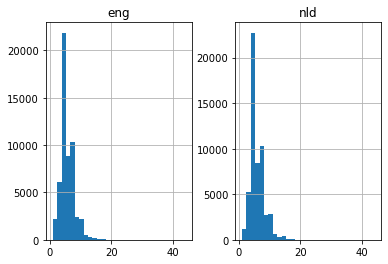

In [32]:
length_df = pd.DataFrame({'eng':eng_l, 'nld':nld_l})
length_df.hist(bins = 30)
plt.show()

In [33]:
max(eng_l)

44

In [34]:
max(nld_l)

44

In [15]:
type(nld_l)
import statistics
statistics.mean(nld_l)

5.853307138179437

In [16]:
statistics.mean(eng_l)

5.619569962890199

Coincidentally the maximum length of the Dutch sentences and that of the English phrases is equal to 44.

5\. **Using train_test_split from sklearn split the dataset into training (80%) and test (20%) sets.**

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(nld_eng, test_size=0.2, random_state = 321)

6\. **Time to tokenize the sentences. The function below uses the Tokenizer function from Keras and fits that on its input text. Apply this function and find out about the vocabulary size for the Dutch and English sets. For this you can use the entire sets.**

In [17]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [18]:
# prepare english tokenizer
eng_tokenizer = tokenization(nld_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 9073


In [19]:
# prepare Dutch tokenizer
nld_tokenizer = tokenization(nld_eng[:, 1])
nld_vocab_size = len(nld_tokenizer.word_index) + 1
print('Dutch Vocabulary Size: %d' % nld_vocab_size)

Deutch Vocabulary Size: 12794


7\. **Write a function to convert tokens to sequences. Also perform sequence padding to a maximum sentence length. Input arguments to this function are tokenizer, maximum_length, and textlines, and its output will be sequences of tokens.**

In [20]:
# encode and pad sequences
def encode_sequences(tokenizer, maximum_length, textlines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(textlines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=maximum_length, padding='post')
    return seq

8\. **Convert your tokenized training data into sequences. Use a maximum length of 20 and name the dataframs train_X and train_Y.**

In [22]:
eng_length = 20
nld_length = 20
# prepare training data
train_X = encode_sequences(nld_tokenizer, nld_length, train[:, 1])
train_Y = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

9\. **In the same way, convert your tokenized test data into sequences and name the dataframs test_X and test_Y.**

In [23]:
# prepare test data
test_X = encode_sequences(nld_tokenizer, nld_length, test[:, 1])
test_Y = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

# Neural Network Model

10\. **Defince a Seq2Seq model architecture using an Embedding layer as the input layer, an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder. Make this a function and name it build_model(). At least make the embedding_size and LSTMunits as input arguments for the function.**

In [43]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, embedding_size, LSTMunits):
    model = Sequential()
    model.add(Embedding(in_vocab, embedding_size, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(LSTMunits))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(LSTMunits, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

11\. **Create a model by calling the function with embedding_size = 300 and LSTMunits = 512.**

In [44]:
model = build_model(nld_vocab_size, eng_vocab_size, nld_length, eng_length, 300, 512)

12\. **Compile the model with the RMSprop optimizer and sparse_categorical_crossentropy for loss.**
Note that we have used 'sparse_categorical_crossentropy' as the loss function as it allows us to use the target sequence as it is instead of one-hot encoded format. One-hot encoding the target sequences with such a huge vocabulary might consume your system's entire memory.

In [ ]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

13\. **Fit the model with 5 epochs, validation_split of 0.2, and batch_size of 128**

In [45]:
filename = 'model.h1.09_jun_21'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=7, batch_size=128, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/7
275/275 [==============================] - ETA: 0s - loss: 1.9605
Epoch 00001: val_loss improved from inf to 1.73187, saving model to model.h1.09_jun_21
INFO:tensorflow:Assets written to: model.h1.09_jun_21\assets
275/275 [==============================] - 441s 2s/step - loss: 1.9605 - val_loss: 1.7319
Epoch 2/7
275/275 [==============================] - ETA: 0s - loss: 1.6299
Epoch 00002: val_loss improved from 1.73187 to 1.57127, saving model to model.h1.09_jun_21
INFO:tensorflow:Assets written to: model.h1.09_jun_21\assets
275/275 [==============================] - 574s 2s/step - loss: 1.6299 - val_loss: 1.5713
Epoch 3/7
275/275 [==============================] - ETA: 0s - loss: 1.4751
Epoch 00003: val_loss improved from 1.57127 to 1.45343, saving model to model.h1.09_jun_21
INFO:tensorflow:Assets written to: model.h1.09_jun_21\assets
275/275 [==============================] - 615s 2s/step - loss: 1.4751 - val_loss: 1.4534
Epoch 4/7
275/275 [==============================]

KeyboardInterrupt: 

14\. **Plot the loss for the training and validations sets.**

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

NameError: name 'history' is not defined

15\. **Predict translations for the test set.**

In [28]:
model = load_model('model.h1.09_jun_21')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
preds

As you noticed preds are only indices of words, so we need to convert them to words to be able to read them.

16\. **Use the function get_word from below to convert an index to a word. Apply it on your predictions.**

In [29]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [30]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
preds_text

17\. **Create a new dataframe with two columns where you show the actual text of the test set versus your predictions. Use the sample() function with your dataframe to randomly check some of the lines.**

In [40]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})


In [41]:
#pd.set_option('display.max_colwidth', 50)


In [42]:
pred_df.head(15)


,actual,predicted
0,i must refuse,i have to
1,they are singers,theyre are
2,who switched off the light,who turned the light
3,tom was really different,tom was really kind
4,do you need anything,do you need something
5,im fixing the clock,i am the clock
6,i cant tell you when tom will get here,i cant tell you when come here
7,he solved the problem with ease,he talked that to this
8,im not suicidal,i dont have any
9,please take another one,please dont a


In [80]:
pred_df


,actual,predicted
0,i must refuse,i have to a
1,they are singers,theyre they
2,who switched off the light,they the
3,tom was really different,tom is have
4,do you need anything,do you need
...,...,...
10990,i told you it was too soon,you to the it
10991,whose book is this,this is this
10992,get out,get
10993,how did your interview go,how did you this


In [81]:
pred_df.sample(15)

,actual,predicted
1542,luckily the weather turned out fine,dont to
2595,have you lost weight,do you like
1315,unfortunately she lives abroad,he was in
9048,there was a pretty girl with black hair in the...,in a in the days
6782,thats the way it goes,is
8634,i think i was the one who suggested that,the was
2541,he cured my illness,he was my
2409,dont forget to tip the waiter,the to
6093,is that a cow or a buffalo,my a my car
6187,tom probably doesnt know where mary is going t...,i when to him


18\. **You may not get very good results mainly because of the memory/time limit that you did not create a very efficient model. For this, we already trained a model with 30 epochs on the entire training dataset. Load this model with load_model('model.h1.09_jun_21') and repeat the steps in 15, 16 and 17 again.**

In [ ]:
model = load_model('model.h1.09_jun_21')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))